In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
import warnings
warnings.filterwarnings("ignore")

In [2]:
# File Directory for train test valid
train_path_str = r'C:\Users\madar\OneDrive\ryuga\OneDrive\Desktop\Ryu-fyp\Data\train'
val_path_str = r'C:\Users\madar\OneDrive\ryuga\OneDrive\Desktop\Ryu-fyp\Data\valid'
test_path_str = r'C:\Users\madar\OneDrive\ryuga\OneDrive\Desktop\Ryu-fyp\Data\test'

In [3]:
# Define function to count number of images per class using a dictionary
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)))
    return num_of_image

# Get the number of images per class in each set (train, validation, and test)
train_set = GetDatasetSize(train_path_str)
val_set = GetDatasetSize(val_path_str)
test_set = GetDatasetSize(test_path_str)
print(train_set, "\n\n", val_set, "\n\n", test_set)

NameError: name 'train_path_str' is not defined

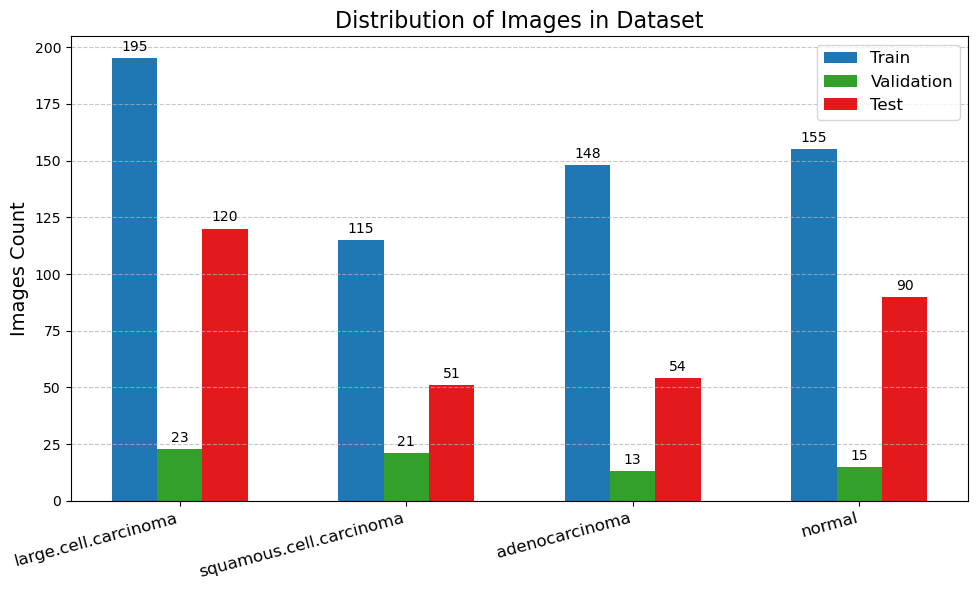

In [5]:
# Labels for each class
labels = ['large.cell.carcinoma', 'squamous.cell.carcinoma', 'adenocarcinoma', 'normal']

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Set a different color scheme
colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00']

# Labels location and bars width
x = np.arange(len(labels))
width = 0.2

# Create plot and 3 sets of bars (train, val, test)
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, train_list, width, label='Train', color=colors[0])
rects2 = ax.bar(x, val_list, width, label='Validation', color=colors[1])
rects3 = ax.bar(x + width, test_list, width, label='Test', color=colors[2])

# Add labels, title, legend, count values...
ax.set_ylabel('Images Count', fontsize=14)
ax.set_title('Distribution of Images in Dataset', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display count values on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Optimized layout and displaying plot
fig.tight_layout()
plt.show()


In [25]:
trainGenertor = ImageDataGenerator(
    rescale = 1.0/255.0,
    preprocessing_function=preprocess_input,
   rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    dtype='float32'
)

train_data = trainGenertor.flow_from_directory(
    train_path_str,
    target_size=(350, 350),  # Adjusted target size to match code 2
    batch_size=5,
    class_mode='categorical'
)

# Dicctionary with class names to their respective indices in the generated data
train_data.class_indices

Found 613 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [26]:
testGenertor = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale = 1.0/255.0,
    dtype='float32'
)

test_data = testGenertor.flow_from_directory(
    test_path_str,
    target_size=(350, 350),  # Adjusted target size to match code 2
    batch_size=5,
    class_mode='categorical',
    shuffle=False
)
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [27]:
valGenertor = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale = 1.0/255.0,
    dtype='float32'
)
val_data = valGenertor.flow_from_directory(
    val_path_str,
    target_size=(350, 350),  # Adjusted target size to match code 2
    batch_size=5,
    class_mode='categorical'
)
val_data.class_indices


Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


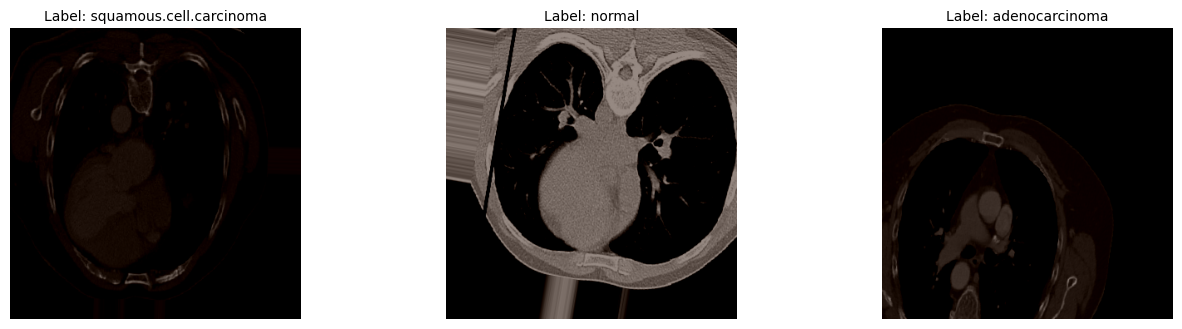

In [32]:
# Function to plot sample images with labels
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))  
    fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

# Sample and plotting of 3 images with their respective labels from train_data
sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

In [29]:
test_classes = os.listdir(test_path_str)
input_shape = (350, 350, 3)  
num_classes = 4

In [17]:
# Define the VGG16-based model architecture from code 2
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

NUM_CLASSES = 4

vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dropout(0.25))
vgg_model.add(Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.hdf5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

call_back = [mc]

# Fitting the Model
vgg = vgg_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=32,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=call_back
)




Epoch 1/32


76/76 [==============================] - ETA: 0s - loss: 1.9499 - accuracy: 0.4364
Epoch 1: val_accuracy improved from -inf to 0.40278, saving model to .\ct_vgg_best_model.hdf5
76/76 [==============================] - 332s 4s/step - loss: 1.9499 - accuracy: 0.4364 - val_loss: 2.7167 - val_accuracy: 0.4028
Epoch 2/32
76/76 [==============================] - ETA: 0s - loss: 2.1181 - accuracy: 0.4512
Epoch 2: val_accuracy did not improve from 0.40278
76/76 [==============================] - 325s 4s/step - loss: 2.1181 - accuracy: 0.4512 - val_loss: 3.0899 - val_accuracy: 0.3333
Epoch 3/32
76/76 [==============================] - ETA: 0s - loss: 1.7706 - accuracy: 0.5322
Epoch 3: val_accuracy improved from 0.40278 to 0.50000, saving model to .\ct_vgg_best_model.hdf5
76/76 [==============================] - 322s 4s/step - loss: 1.7706 - accuracy: 0.5322 - val_loss: 1.1719 - val_accuracy: 0.5000
Epoch 4/32
76/76 [==============================] - ETA: 0s - loss: 1.7749 - accu

76/76 [==============================] - 392s 5s/step - loss: 1.2683 - accuracy: 0.7008 - val_loss: 1.9558 - val_accuracy: 0.5972
Epoch 26/32
76/76 [==============================] - ETA: 0s - loss: 0.9749 - accuracy: 0.7306
Epoch 26: val_accuracy did not improve from 0.73611
76/76 [==============================] - 396s 5s/step - loss: 0.9749 - accuracy: 0.7306 - val_loss: 2.4802 - val_accuracy: 0.5556
Epoch 27/32
76/76 [==============================] - ETA: 0s - loss: 1.2017 - accuracy: 0.6942
Epoch 27: val_accuracy did not improve from 0.73611
76/76 [==============================] - 389s 5s/step - loss: 1.2017 - accuracy: 0.6942 - val_loss: 1.3041 - val_accuracy: 0.7222
Epoch 28/32
76/76 [==============================] - ETA: 0s - loss: 1.2251 - accuracy: 0.6893
Epoch 28: val_accuracy did not improve from 0.73611
76/76 [==============================] - 389s 5s/step - loss: 1.2251 - accuracy: 0.6893 - val_loss: 3.9090 - val_accuracy: 0.4028
Epoch 29/32
76/76 [====================

In [18]:
from tensorflow.keras.models import load_model
model = load_model("./ct_vgg_best_model.hdf5")

# Checking the Accuracy of the Model 
result = model.evaluate(test_data)
accuracy_incep = result[1]
loss_incep = result[0]

print(f"The accuracy of the model is = {accuracy_incep*100} %")

print(f"The loss the model is = {loss_incep}%")

40/40 [==============================] - 184s 5s/step - loss: 1.2842 - accuracy: 0.6540
The accuracy of the model is = 65.39682745933533 %
The loss the model is = 1.284179925918579%


In [19]:
base_model = EfficientNetB0(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

16705208/16705208 [==============================] - 8s 0us/step


In [20]:
# The code then iterates through all layers in the base InceptionV3 model. 
# This means that during training, these layers will not be updated, preserving the pre-trained knowledge.
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# We aded another layer for better understanding of the flattened information
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
x = layers.Dense(4, activation='sigmoid')(x)

# We put together the original InceptionV3 and our new custom parts 
model_incep = tf.keras.models.Model(base_model.input, x)

# Compile up the rules and tools for training your neural network. 
# The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

In [22]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_incep_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [33]:
# Fitting the Model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 1.3780 - accuracy: 0.3191
Epoch 1: val_accuracy did not improve from 0.31944
122/122 [==============================] - 111s 910ms/step - loss: 1.3780 - accuracy: 0.3191 - val_loss: 1.3872 - val_accuracy: 0.3000
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.3777 - accuracy: 0.3207
Epoch 2: val_accuracy did not improve from 0.31944
122/122 [==============================] - 112s 915ms/step - loss: 1.3777 - accuracy: 0.3207 - val_loss: 1.3860 - val_accuracy: 0.3143
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.3779 - accuracy: 0.3174
Epoch 3: val_accuracy did not improve from 0.31944
122/122 [==============================] - 115s 941ms/step - loss: 1.3779 - accuracy: 0.3174 - val_loss: 1.3864 - val_accuracy: 0.3143
Epoch 4/32
122/122 [==============================] - ETA: 0s - loss: 1.3776 - accuracy: 0.3174
Epoch 4: val_accuracy improved from 0.31944 to 0.32857, sa

Epoch 30/32
122/122 [==============================] - ETA: 0s - loss: 1.3722 - accuracy: 0.3207
Epoch 30: val_accuracy did not improve from 0.32857
122/122 [==============================] - 130s 1s/step - loss: 1.3722 - accuracy: 0.3207 - val_loss: 1.3826 - val_accuracy: 0.3286
Epoch 31/32
122/122 [==============================] - ETA: 0s - loss: 1.3724 - accuracy: 0.3174
Epoch 31: val_accuracy did not improve from 0.32857
122/122 [==============================] - 125s 1s/step - loss: 1.3724 - accuracy: 0.3174 - val_loss: 1.3867 - val_accuracy: 0.3143
Epoch 32/32
122/122 [==============================] - ETA: 0s - loss: 1.3731 - accuracy: 0.3158
Epoch 32: val_accuracy did not improve from 0.32857
122/122 [==============================] - 119s 976ms/step - loss: 1.3731 - accuracy: 0.3158 - val_loss: 1.3868 - val_accuracy: 0.3143


In [34]:
# Loading the Best Fit Model 
model = load_model("./ct_incep_best_model.hdf5")

# Checking the Accuracy of the Model 
accuracy_incep = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_incep*100} %")
loss_incep = model.evaluate_generator(generator= test_data)[0]
print(f"The loss the model is = {loss_incep}%")

The accuracy of the model is = 38.0952388048172 %
The loss the model is = 1.3690822124481201%


In [35]:
base_model = EfficientNetB0(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

In [36]:
mc = ModelCheckpoint(
    filepath="./ct_effnet_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [ mc];

tensorboard = TensorBoard(log_dir = 'logs')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

#We also add a earlystop for prevent the computer from wasting time if it's not making progress.


early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

In [37]:
#Customize our base model
EffNetmodel = base_model.output
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)
# to provide overfitting problem
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

#Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [38]:
#We put together the original EfficientNetB0 and our new custom parts 
EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)

#Compile up the rules and tools for training your neural network. 
#The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [39]:
%time
EffNetB0 = EffNetmodel.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = [tensorboard, mc, reduce_lr, early_stopping]
    )

Wall time: 0 ns
Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 1.0943 - accuracy: 0.5148
Epoch 1: val_accuracy improved from -inf to 0.24286, saving model to .\ct_effnet_best_model.hdf5
122/122 [==============================] - 365s 2s/step - loss: 1.0943 - accuracy: 0.5148 - val_loss: 1.7469 - val_accuracy: 0.2429 - lr: 0.0010
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.5576
Epoch 2: val_accuracy improved from 0.24286 to 0.32857, saving model to .\ct_effnet_best_model.hdf5
122/122 [==============================] - 216s 2s/step - loss: 1.0102 - accuracy: 0.5576 - val_loss: 1.5356 - val_accuracy: 0.3286 - lr: 0.0010
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 0.9311 - accuracy: 0.5987
Epoch 3: val_accuracy did not improve from 0.32857
122/122 [==============================] - 248s 2s/step - loss: 0.9311 - accuracy: 0.5987 - val_loss: 1.5036 - val_accuracy: 0.1857 - lr: 0.0010
Epoch 4/32
12

Epoch 18/32
122/122 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8799
Epoch 18: val_accuracy did not improve from 0.84286
122/122 [==============================] - 269s 2s/step - loss: 0.3146 - accuracy: 0.8799 - val_loss: 1.5759 - val_accuracy: 0.6571 - lr: 2.4300e-06
Epoch 19/32
122/122 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8832
Epoch 19: val_accuracy did not improve from 0.84286

Epoch 19: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
122/122 [==============================] - 260s 2s/step - loss: 0.3152 - accuracy: 0.8832 - val_loss: 0.8543 - val_accuracy: 0.7857 - lr: 2.4300e-06
Epoch 20/32
122/122 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.8980
Epoch 20: val_accuracy did not improve from 0.84286
122/122 [==============================] - 213s 2s/step - loss: 0.2899 - accuracy: 0.8980 - val_loss: 0.7879 - val_accuracy: 0.8286 - lr: 7.2900e-07
Epoch 21/32
122/122 [=======

In [40]:
# Loading the Best Fit Model 
model_eff = load_model("./ct_effnet_best_model.hdf5")

# Checking the Accuracy of the Model 
accuracy_effnet = model_eff.evaluate_generator(generator= test_data)[1] 
loss_effnet = model_eff.evaluate_generator(generator= test_data)[0]
print(f"The accuracy of the model is = {accuracy_effnet*100} %")
print(f"The loss of the model is = {loss_effnet} %")

The accuracy of the model is = 82.53968358039856 %
The loss of the model is = 0.4960501194000244 %


In [43]:
def chestScanPrediction(path, _model, actual_label):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    num_images = len(paths)
    for i in range(num_images):
        # Loading Image
        img = image.load_img(paths[i], target_size=(350, 350))

        # Normalizing Image
        norm_img = image.img_to_array(img) / 255

        # Converting Image to Numpy Array
        input_arr_img = np.array([norm_img])

        # Getting Predictions
        pred = np.argmax(_model.predict(input_arr_img))

        # Printing Model Prediction
        print("Predicted Label:", classes_dir[pred])
        print("Actual Label:", classes_dir[actual_label[i]])
        
        # Displaying the image
        plt.imshow(img)
        plt.title("Actual Label: " + classes_dir[actual_label[i]] + "\nPredicted Label: " + classes_dir[pred])
        plt.show()

1/1 [==============================] - 3s 3s/step
Predicted Label: Squamous cell carcinoma
Actual Label: Large cell carcinoma


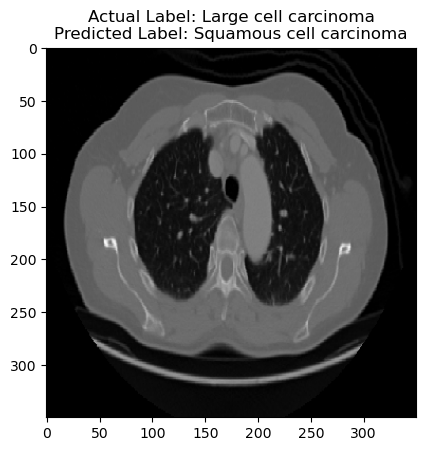

1/1 [==============================] - 1s 1s/step
Predicted Label: Adenocarcinoma
Actual Label: Adenocarcinoma


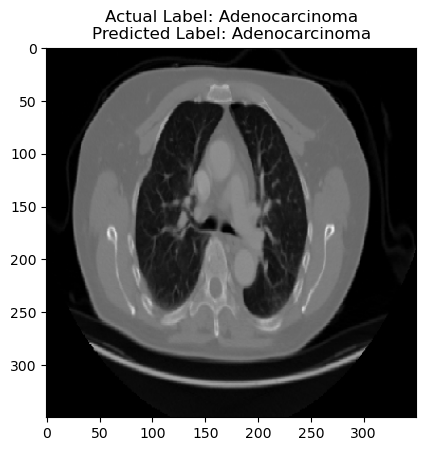

1/1 [==============================] - 1s 1s/step
Predicted Label: Normal
Actual Label: Normal


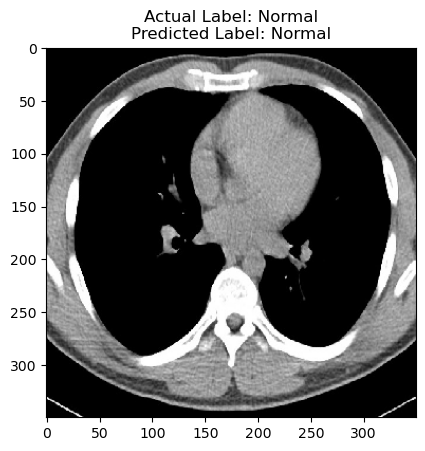

1/1 [==============================] - 1s 1s/step
Predicted Label: Squamous cell carcinoma
Actual Label: Squamous cell carcinoma


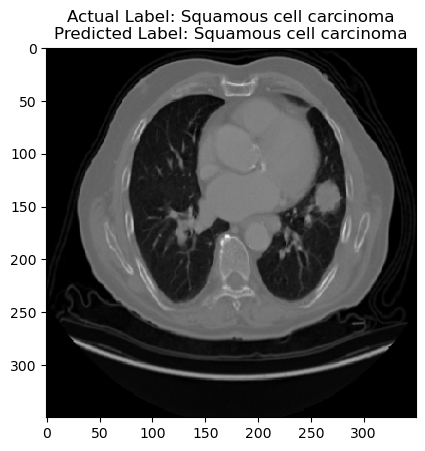

In [50]:
paths = [
    r"C:\Users\madar\OneDrive\ryuga\OneDrive\Desktop\Ryu-fyp\Data\test\large.cell.carcinoma\000128.png",
    r"C:\Users\madar\OneDrive\ryuga\OneDrive\Desktop\Ryu-fyp\Data\test\adenocarcinoma\000114.png",
    r"C:\Users\madar\OneDrive\ryuga\OneDrive\Desktop\Ryu-fyp\Data\test\normal\21.png",
    r"C:\Users\madar\OneDrive\ryuga\OneDrive\Desktop\Ryu-fyp\Data\test\squamous.cell.carcinoma\000119.png"
]

actual_labels = [1, 0, 2, 3]

chestScanPrediction(paths, vgg_model, actual_labels)

In [48]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
accuracy = [accuracy_vgg, accuracy_incep, accuracy_effnet]
accuracy = np.floor([i * 100 for i in accuracy])


fig, ax = plt.subplots()
bars = ax.bar(algos, accuracy, color='skyblue')

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

NameError: name 'accuracy_vgg' is not defined